# Projekt 1 - UTA

Autorzy: Mikołaj Nowak 151813, Anna Roszkiewicz 151883

## Informacja preferencyjna

### Definicja problemu

Celem jest uszeregowanie 27 możliwych wariantów utilizacji odpadów radioaktywnych. Każdy z wariantów charakteryzuje się jednym z trzech scenariuszy czasowych (S1, S2, S3), jedną z trzech lokalizacji (R1, R2, R3) oraz jedną z trzech metod finansowania (F1, F2, F3).

Na tej podstawie, każdy wariant został oceniony na czterech kryteriach typu koszt:
- C1: całkowity koszt,
- C2: koszty poniesione przez obecnych konsumentów (przez pierwsze 30 lat),
- C3: koszty poniesione przez przyszłych konsumentów (po upływie 30 lat),
- C4: ryzyko finansowe.

Dane zaczerpnięte zostały z artykułu Briggs, T., Kunsch, P. L., & Mareschal, B. (1990). Nuclear waste management: An application of the multicriteria PROMETHEE methods. European Journal of Operational Research, 44(1), 1–10.

Charakterystykę wariantów przedstawiono w poniższej tabeli:

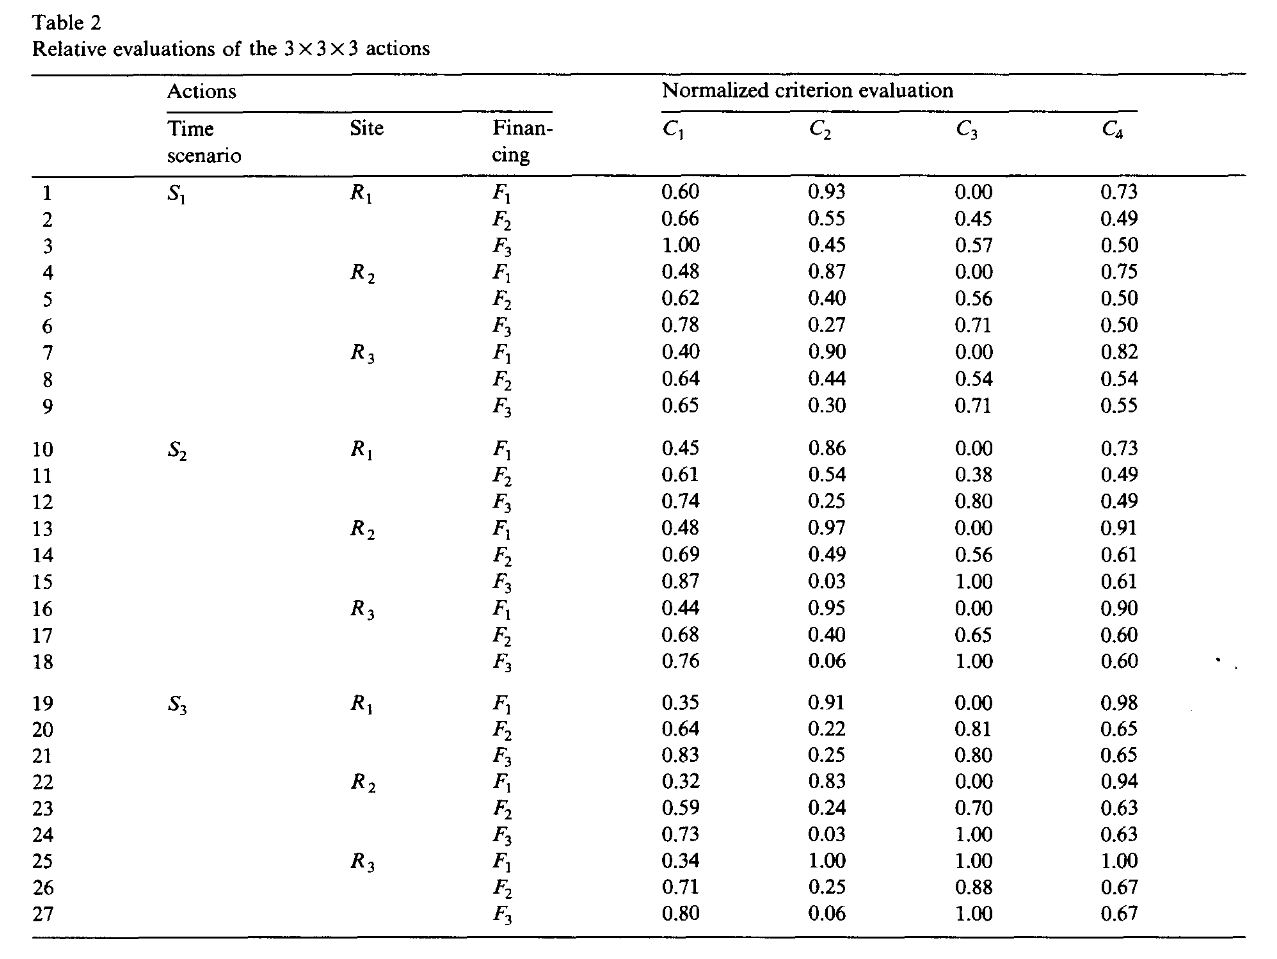

### Polityka firmy

Podczas tworzenia rankingu częściowego będziemy kierować się następującą polityką:

- Wydajność produkcji energii elektrycznej wzrośnie w przyszłości. Dodatkowo nie chcę brać pożyczek. (1)
- Preferowana jest lokalizacja R2 nad R1 oraz R1 nad R3. (4)

Drugi warunek jest łatwy do interpretacji - odnosi się jedynie do lokalizacji składowiska.

Pierwszy warunek odnosi się do metod finansowania przedsięwzięcia. Negatywnie oceniamy warianty z metodą finansowania F3, która zakłada wzięcie pożyczki. Znacznie wolimy metodę finansowania F1.

W przypadku konfliktu jako nadrzędne będziemy traktowali drugie kryterium, ponieważ jest konkretnie sformułowane.

### Pary wariantów referencyjnych

Utworzymy ranking częściowy poprzez porównanie parami następujących wariantów:

- wariant 12 i wariant 19
- wariant 11 i wariant 25
- wariant 1 i wariant 27
- wariant 1 i wariant 4
- wariant 19 i wariant 21

### Porównania parami

- $ 19 > 12 $, ponieważ warianty mają taką samą lokalizację (R1), a wariant 12 ma metodę finansowania, której chcemy unikać (F3)
- $ 11 > 25 $, ponieważ preferujemy lokalizację R1 nad R3
- $ 1 > 27 $, ponieważ preferujemy lokalizację R1 nad R3, a także metodę finansowania F1 nad F3
- $ 4 > 1 $, ponieważ preferujemy lokalizację R2 nad R1
- $ 19 > 21 $, ponieważ preferujemy metodę finansowania F1 nad F3

## Solver UTA

### Wczytanie danych

In [73]:
import pandas

data = pandas.read_csv("Nuclear waste management.csv")
data.columns = ["ID", "C1", "C2", "C3", "C4"]
display(data.style.hide())

ID,C1,C2,C3,C4
1,0.600000,0.930000,0.000000,0.730000
2,0.660000,0.550000,0.450000,0.490000
3,1.000000,0.450000,0.570000,0.500000
4,0.480000,0.870000,0.000000,0.750000
5,0.620000,0.400000,0.560000,0.500000
6,0.780000,0.270000,0.710000,0.500000
7,0.400000,0.900000,0.000000,0.820000
8,0.640000,0.440000,0.540000,0.540000
9,0.650000,0.300000,0.710000,0.550000
10,0.450000,0.860000,0.000000,0.730000


### Definicja problemu programowania matematycznego

In [74]:
!pip install pulp
from pulp import LpProblem, LpVariable, LpMaximize, lpSum, value, LpStatus

In [75]:
# definicja funkcji celu
prob = LpProblem("UTA", LpMaximize)
e = LpVariable(name="e", lowBound=0, upBound=1)
prob += e

# utworzenie zmiennych decyzyjnych dla kryteriów
criterion_vars = {}
for column in data:
    if column != "ID":
        criterion_vars[column] = {val: LpVariable(f"{column}_{val}", lowBound=0, upBound=1) for val in data[column].values}

# dodanie ograniczeń UTA
sum_max = 0
for column in data:
    if column != "ID":
        values = data[column].values.tolist()

        # monotoniczność - sortowanie rosnąco, kryterium typu koszt
        values.sort()
        for i in range(len(values) - 1):
            prob += criterion_vars[column][values[i]] >= criterion_vars[column][values[i+1]], f"Monotonicity_{column}_{i}"

        # dodatkowe ograniczenie - minimalna waga kryterium 0.1 - przyjmujemy ją dla najgorszej, czyli największej wartości
        max_val = max(values)
        prob += criterion_vars[column][max_val] == 0.1, f"Normalize_{column}_Lowest"

        # normalizacja - suma najlepszych wartości równa 100
        min_val = min(values)
        sum_max += criterion_vars[column][min_val] 
prob += sum_max == 1, "Normalize_Criteria_Sum"

# utworzenie zmiennych definiujących użyteczność wariantów
utilities = []
utilities.append(0) # warianty są numerowane od 1
for i, variant in data.iterrows():
    u = LpVariable(f"U_{i+1}", lowBound=0)
    utilities.append(u)
    prob += u == lpSum([
        criterion_vars["C1"][variant["C1"]],
        criterion_vars["C2"][variant["C2"]],
        criterion_vars["C3"][variant["C3"]],
        criterion_vars["C4"][variant["C4"]]
    ]), f"Utility_{i+1}"

# dodanie ograniczeń z porównań parami
prob += utilities[19] >= utilities[12] + e, "Prefer_19_over_12"
prob += utilities[11] >= utilities[25] + e, "Prefer_11_over_25"
prob += utilities[1] >= utilities[27] + e, "Prefer_1_over_27"
prob += utilities[4] >= utilities[1] + e, "Prefer_4_over_1"
prob += utilities[19] >= utilities[21] + e, "Prefer_19_over_21"

### Rozwiązanie problemu

In [76]:
prob.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ania/mgr/decision-support/.venv/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/linux/i64/cbc /tmp/2a37f2a4a1c247fca1548a2be4a20651-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/2a37f2a4a1c247fca1548a2be4a20651-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 146 COLUMNS
At line 483 RHS
At line 625 BOUNDS
At line 704 ENDATA
Problem MODEL has 141 rows, 105 columns and 304 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 57 (-84) rows, 53 (-52) columns and 153 (-151) elements
Perturbing problem by 0.001% of 1 - largest nonzero change 0.00054770087 ( 0.054770087%) - largest zero change 0.0003936718
0  Obj -0.00011360363 Primal inf 1.1999915 (8) Dual inf 0.9994513 (1)
31  Obj 0.29908299 Primal inf 0.399996 (4)
52  Obj 0.25608239
Optimal - objective value 0.25714286
After Po

1

In [77]:
import numpy as np

print(f"Status: {LpStatus[prob.status]}")
print("\nWartość funkcji celu:", value(prob.objective))

Status: Optimal

Wartość funkcji celu: 0.25714286


### Ranking wariantów

Poniższa tabela przedstawia uzyskany ranking wraz z wartościami funkcji użyteczności oraz informacją, czy dany wariant był wykorzystany jako wariant referencyjny.

In [78]:
import numpy as np

values = data["C1"].values.tolist()

ranking = [0 for i in range(len(values))]

for var in prob.variables():
    if var.name[0] == "U":
        number = int(var.name[2:])
        ranking[number-1] = value(var) 

is_reference = [0 for i in range(len(values))]
reference_variants = [1, 4, 11, 12, 19, 21, 25, 27]
for i in reference_variants:
    is_reference[i-1] = 1

data['U'] = ranking
data['Referencyjny'] = is_reference
data = data.sort_values('U', ascending=False)

display(data.style.hide())

ID,C1,C2,C3,C4,U,Referencyjny
4,0.480000,0.870000,0.000000,0.750000,1.000000,1
10,0.450000,0.860000,0.000000,0.730000,1.000000,0
22,0.320000,0.830000,0.000000,0.940000,1.000000,0
16,0.440000,0.950000,0.000000,0.900000,0.914286,0
19,0.350000,0.910000,0.000000,0.980000,0.914286,1
13,0.480000,0.970000,0.000000,0.910000,0.914286,0
7,0.400000,0.900000,0.000000,0.820000,0.914286,0
11,0.610000,0.540000,0.380000,0.490000,0.828571,1
1,0.600000,0.930000,0.000000,0.730000,0.742857,1
23,0.590000,0.240000,0.700000,0.630000,0.657143,0


### Wykresy cząstkowych funkcji użyteczności

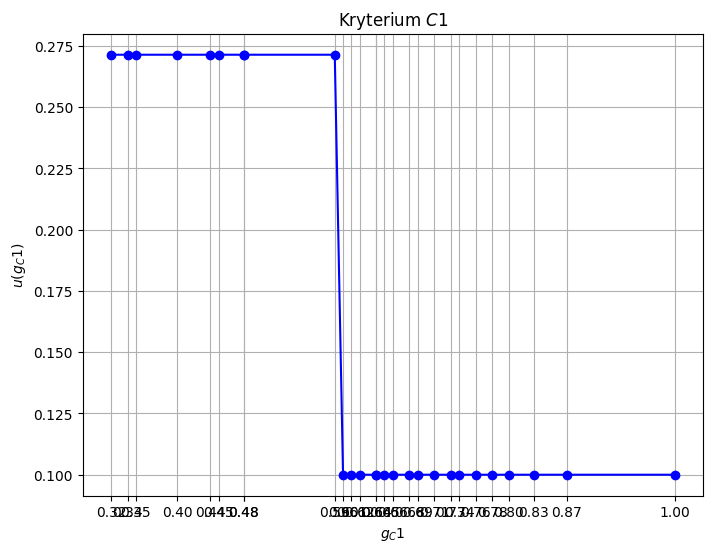

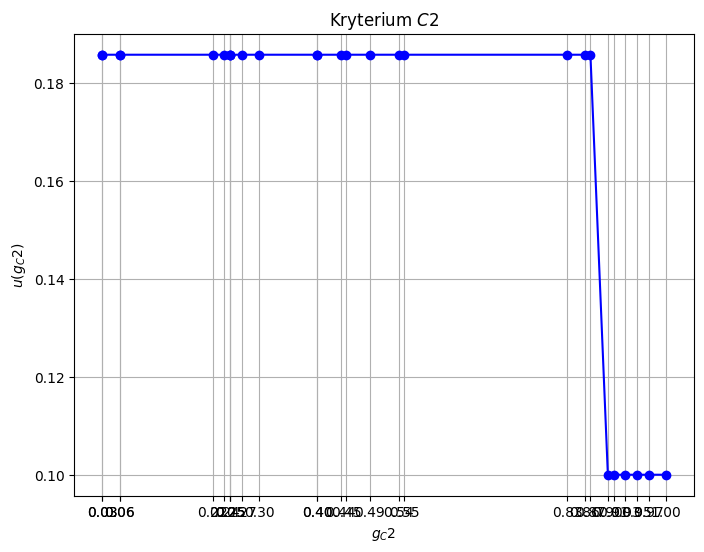

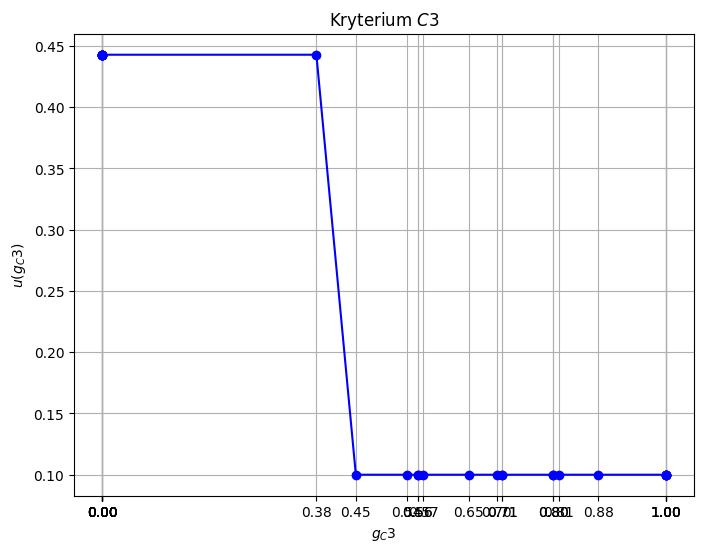

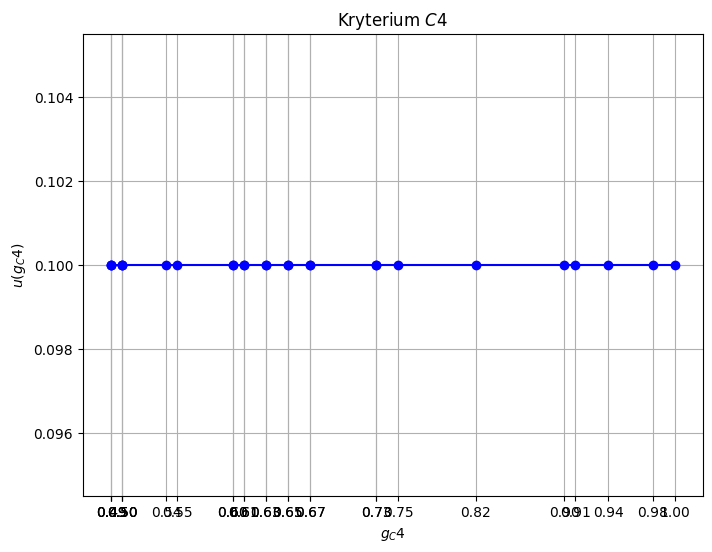

In [79]:
import matplotlib.pyplot as plt

for column in data.columns:
    if column in ["C1", "C2", "C3", "C4"]:
        values = data[column].values.tolist()
        values.sort()

        solver_values_C1 = [value(criterion_vars[column][val]) for val in values]

        plt.figure(figsize=(8, 6))
        plt.plot(values, solver_values_C1, marker='o', linestyle='-', color='b', label=f'$u(g_{column})$')
        plt.xlabel(f'$g_{column}$')
        plt.ylabel(f'$u(g_{column})$')
        plt.title(f'Kryterium ${column}$')
        plt.xticks(data[column].values)
        plt.grid(True)
        plt.show()

## Analiza wyników

### Zgodność wyników z informacją preferencyjną

Uzyskany ranking jest zgodny z rankingiem częściowym podanym w ramach informacji preferencyjnej.

- $ U(12) = 0,49 \land U(19) = 0,91 $, zatem $ 19 > 12 $
- $ U(11) = 0,83 \land U(25) = 0,57 $, zatem $ 11 > 25 $
- $ U(1) = 0,74 \land U(27) = 0,49 $, zatem $ 1 > 27 $
- $ U(4) = 1,00 \land U(1) = 0,74 $, zatem $ 4 > 1 $
- $ U(19) = 0,91 \land U(21) = 0,49 $, zatem $ 19 > 21 $

### Spójność z informacja preferencyjną dla wariantów niereferencyjnych

Warianty niereferencyjne w dużej mierze również uporządkowane są zgodnie z informacją preferencyjną, przykładowo:

- $ 13 > 23 $ - oba warianty mają lokalizację R2, natomiast wariant 13 ma preferowaną przez nas metodę finansowania F1
- $ 22 > 16 $ - wariant 22 ma lokalizację R2, a wariant 16 ma lokalizację R3
- $ 23 > 8 $ - wariant 23 ma lokalizację R2, a wariant 8 ma lokalizację R3

Wiele wariantów zostało jednak uznanych za nierozróżnialne.

### Najlepsze strategie

Najlepszą ocenę uzyskały trzy strategie:
- $ 4: S1 \times R2 \times F1 $
- $ 10: S2 \times R1 \times F1 $
- $ 22: S3 \times R2 \times F1 $

Wszystkie trzy charakteryzują się najbardziej preferowaną przez nas metodą finansowania F1, a dwa z nich mają także najbardziej preferowaną przez nas lokalizację R2.

### Najgorsze strategie

Jako najgorsze ocenione zostało aż 16 strategii. Są to w większości strategie charakteryzujące się najmniej przez nas preferowaną metodą finansowania F3 lub najmniej preferowaną lokalizacją R3.

### Wpływ kryteriów na ostateczny wynik

Największy wpływ na końcowy wynik miało kryterium C3, na którym waga dla najlepszych wartości jest równa prawie 0,45. 

Najmniejszy wpływ miało kryterium C4, które dla wszystkich wartości przyjęło minimalną wagę 0.1.

## UTA GMS

## Reprezentatywna funkcja użyteczności